## Подготовка данных

In [ ]:
import shutil
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.python.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file = '/content/drive/MyDrive/машинное зрение/Cat_Breed.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

['.config', 'drive', '__MACOSX', 'Cat_Breed', 'sample_data']


В наборе данных есть несколько папок с изображениями. Внутри каждой папки лежат изображения соответствующего класса. Например, фотографии Регдоллов находятся здесь:

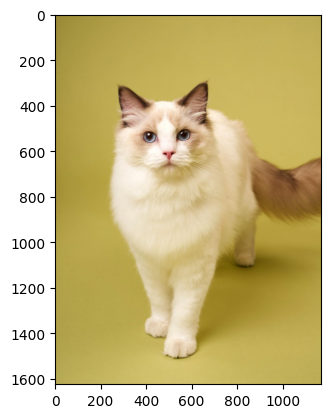

In [ ]:
image = Image.open('Cat_Breed/Regdoll/regdoll_47.jpg')
plt.imshow(np.array(image))
plt.show()

А фотографии Мейн-кунов тут:

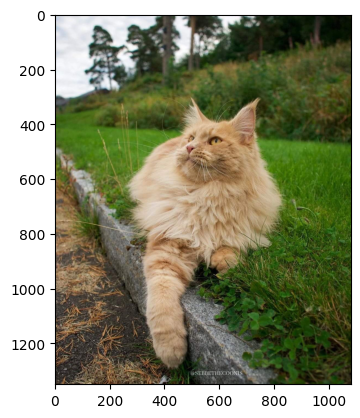

In [ ]:
image = Image.open('Cat_Breed/Maine Coon/mainecoon_315.jpg')
plt.imshow(np.array(image))
plt.show()

Массивы хранятся не на жёстком диске компьютера, а только в оперативной памяти. Ресурсы оперативной памяти не безграничны!

Чтобы справиться с таким объёмом изображений, к работе подключают динамическую загрузку данных.
В библиотеке `Keras` есть удобный загрузчик `ImageDataGenerator` (англ. «генератор данных изображений»):

Из фотографий в папках класс `ImageDataGenerator` формирует батчи с изображениями и метками классов:

In [ ]:
# data generator
datagen = ImageDataGenerator()

Чтобы загрузчик извлёк данные из папки, вызовите функцию `flow_from_directory()` (англ. «поток из директории»):

In [ ]:
datagen_flow = datagen.flow_from_directory(
    # папка, в которой хранится датасет
    'Cat_Breed',
    # к какому размеру приводить изображения
    target_size=(224, 224),
    # размер батча
    batch_size=64,
    # в каком виде выдавать метки классов
    class_mode='sparse',
    # фиксируем генератор случайных чисел (от англ. random seed)
    seed=12345)


Found 5499 images belonging to 11 classes.


Загрузчик нашёл 11 классов (папок), всего в них 5499 изображений.

Значения некоторых аргументов:
* `target_size=(224, 224)` — аргумент с шириной и высотой, к которым будут приводиться изображения. В папках могут лежать изображения разного размера, а нейронным сетям нужно, чтобы все изображения были одинаковые.
* `batch_size=16` — количество изображений в батче. Чем больше изображений, тем лучше обучится сеть. Много фотографий в памяти GPU не поместится, поэтому 16 — это золотая середина, с которой можно стартовать.
* `сlass_mode='sparse'` — аргумент, который указывает тип выдачи метки классов. `sparse` (англ. «редкий») означает, что метки будут порядковым номером папки.
  
  
Узнать, как номера классов связаны с названиями папок, можно так:

In [ ]:
# индексы классов
print(datagen_flow.class_indices)

{'Abyssinian': 0, 'Bombay': 1, 'Egyptian Mau': 2, 'Exotic Shorthair': 3, 'Himalayan': 4, 'Maine Coon': 5, 'Regdoll': 6, 'Russian Blue': 7, 'Scottish Fold': 8, 'Siamese': 9, 'Sphynx': 10}


Применим метод `datagen.flow_from_directory(...)`, чтобы получить объект, у которого пары «картинки — метки». Для этого используем функцию `next()` (англ. «следующий»):

In [ ]:
features, target = next(datagen_flow)

print(features.shape)

(64, 224, 224, 3)


Получились признаки — четырёхмерный тензор, в котором 16 изображений размером 150x150 с тремя цветовыми каналами.

Чтобы обучить на этих данных модель, передайте объект `datagen_flow` в метод `fit()`. Эпоха не должна быть бесконечно длинной. Для этого укажите в параметре `steps_per_epoch` количество батчей в наборе данных:

``` python
model.fit(datagen_flow, steps_per_epoch=len(datagen_flow))

```

Выводим 16 изображений


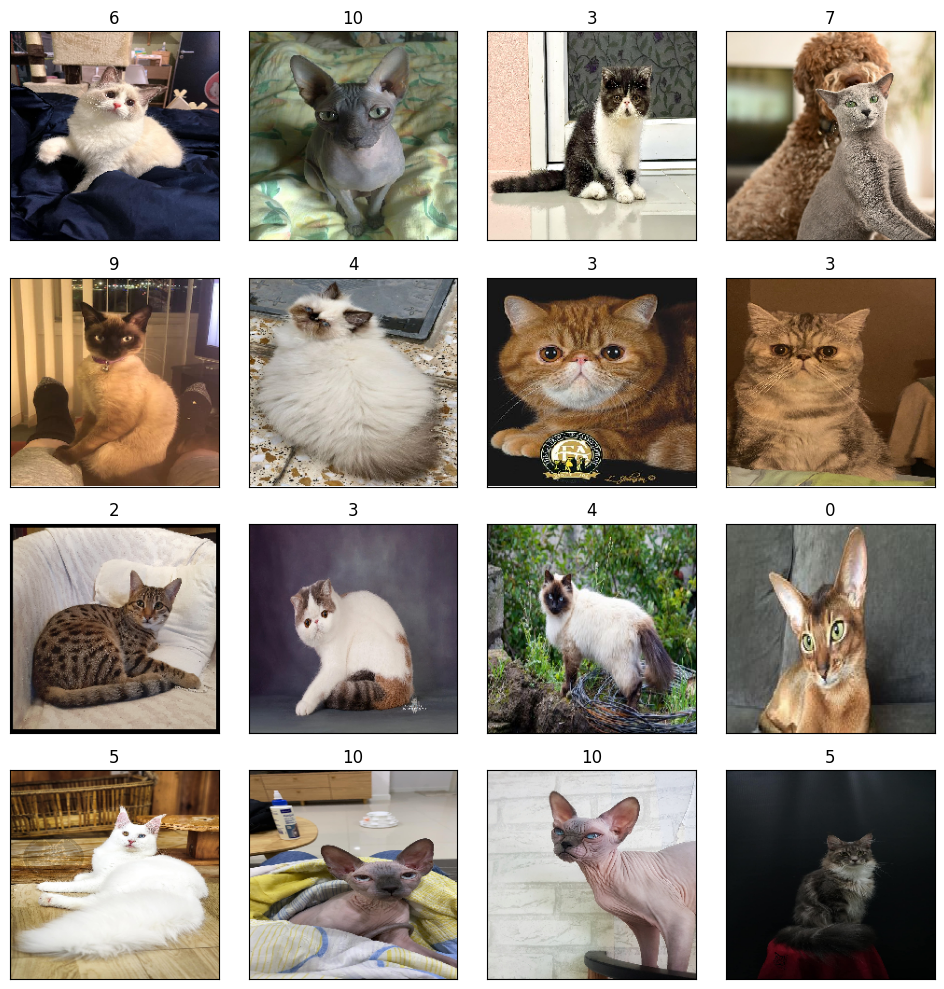

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i].astype('uint8'))
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title(int(target[i]))
    plt.tight_layout()

Создадим два загрузчика: для обучающей и валидационной выборок.

Сделаем предобработку данных: поделите значения яркости на 255. Для этого передайте специальный аргумент в загрузчик `ImageDataGenerator` (найдите в документации), в котором будет указано, что делить нужно на 255.


In [ ]:
batch_size=64
image_size=(224, 224)

In [ ]:
# указываем загрузчику, что валидация содержит
# 20% случайных объектов
datagen = ImageDataGenerator(validation_split=0.20,
                             rescale=1. / 255)

train_datagen_flow = datagen.flow_from_directory(
    'Cat_Breed',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    # указываем, что это загрузчик для обучающей выборки
    subset='training',
    seed=12345)

val_datagen_flow = datagen.flow_from_directory(
    'Cat_Breed',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    # указываем, что это загрузчик для валидационной выборки
    subset='validation',
    seed=12345)

Found 4400 images belonging to 11 classes.
Found 1099 images belonging to 11 classes.


## Обучение модели CNN

Создадим сверточную нейронную сеть с двумя слоями свертки, функцией активации `ReLU` и одним полносвязным слоем для классификации.

Свёрточные слои `Conv2D` (от англ. `two-dimensonal convolution`) создаются так:

`keras.layers.Conv2D(filters, kernel_size, strides, padding, activation) `

Параметры слоя:
* `filters` — количество фильтров, которому равна величина выходного тензора.
* `kernel_size` (англ. «размер ядра свёртки») — пространственный размер фильтра `K`. Повторим, фильтр — это тензор размером `K×K×D`, где `D` равна глубине входного изображения.
* `strides` — размер шага свёртки. По умолчанию величина `strides` равна единице.
* `padding` — толщина отбивки из нулей. Есть два типа паддинга: `valid` («допустимый») и `same` («одинаковый»). Тип паддинга по умолчанию — `valid`, то есть нулевой. Тип `same` означает автоматический подбор величины паддинга так, чтобы ширина и высота выходного тензора была равна ширине и высоте входного тензора.
* `activation` — активация, которую применяют сразу же после свёртки с фильтром. Можно указать знакомые вам функции активации: `'relu'` и `'sigmoid'`. По умолчанию этот параметр равен `None`, то есть активация отключена.


Чтобы результаты свёрточного слоя можно было передать полносвязному слою, подключите слой `Flatten` (англ. «разглаживать»). Он делает многомерный тензор одномерным.



In [ ]:
model_CNN = keras.Sequential([
                          Conv2D(filters=16, kernel_size=3, padding = 'same', input_shape=(224, 224, 3), activation = 'relu'),
                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(filters=32, kernel_size=3, activation = 'relu'),
                          #BatchNormalization(),
                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(filters=64, kernel_size=3, activation = 'relu'),

                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(filters=64, kernel_size=3, activation = 'relu'),
                          BatchNormalization(),
                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(filters=128, kernel_size=3, activation = 'relu'),
                          BatchNormalization(),
                          MaxPooling2D(pool_size=(2, 2)),
                          Flatten(),
                          Dense(128, activation = 'relu'),
                          Dropout(0.5),
                          Dense(11, activation= 'softmax')

])

print(model_CNN.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 546,283 (2.08 MB)

 Trainable params: 545,899 (2.08 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [ ]:
# Компилируем и обучаем модель
model_CNN.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=2, verbose = 1)

hist_CNN = model_CNN.fit(train_datagen_flow,
          validation_data=val_datagen_flow, batch_size = batch_size,
          # Чтобы обучение не было слишком долгим, указываем
          # количество эпох равным 15
          epochs=10, callbacks=[early_stopping_callback])
print("Обучение остановлено после ", early_stopping_callback.stopped_epoch, 'эпох')



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.1674 - loss: 2.8359 - val_accuracy: 0.1510 - val_loss: 2.4072
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 874ms/step - accuracy: 0.2585 - loss: 2.1419 - val_accuracy: 0.1465 - val_loss: 2.5989
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 867ms/step - accuracy: 0.2906 - loss: 2.0079 - val_accuracy: 0.2311 - val_loss: 2.2671
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 87s 942ms/step - accuracy: 0.3308 - loss: 1.9117 - val_accuracy: 0.2948 - val_loss: 2.0743
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.3867 - loss: 1.7792 - val_accuracy: 0.2266 - val_loss: 2.4805
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 958ms/step - accuracy: 0.4294 - loss: 1.6645 - val_accuracy: 0.2821 - val_loss: 2.7871
Epoch 6: early stopping
Обучение остановлено после  5 эпох


Построим кривые обучения

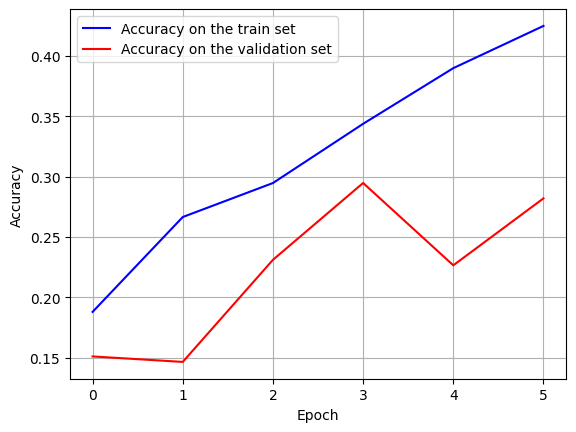

In [ ]:
plt.plot(hist_CNN.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_CNN.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

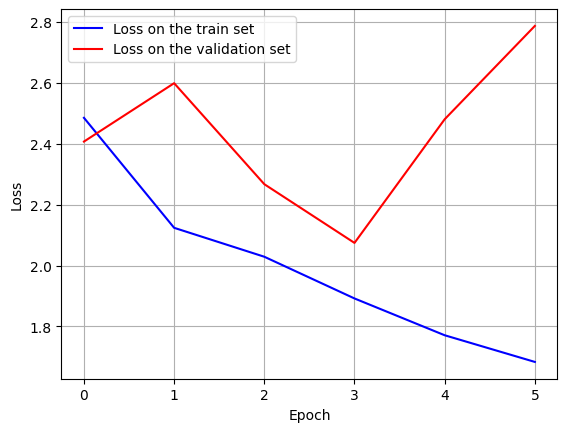

In [ ]:
plt.plot(hist_CNN.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_CNN.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Видим явное переобучение модели.

## Аугментация данных

Ранее вы познакомились с аугментациями — способом увеличить выборку изображений для повышения качества моделей. Теперь научимся добавлять аугментации более простым способом — с помощью Keras.

В `ImageDataGenerator` есть опции для добавления аугментаций. По умолчанию они отключены. Так применяются отражения по вертикали (англ. `vertical flip`):
``` python
datagen = ImageDataGenerator(validation_split=0.25,
                             rescale=1./255,
                             vertical_flip=True)
```

Для обучающей и валидационной выборок нужно создать разные генераторы. Чтобы обучающая и валидационная выборки не содержали общих элементов, задайте объектам `train_datagen_flow` и `val_datagen_flow` одинаковое значение `seed`.

Выполним аугментацию обучающей выборки (`train_datagen`).

Применим к ней такие операции:
* Отражения по вертикали и горизонтали,
* Повороты до 90 градусов,
* Сдвиги изображения по вертикали и горизонтали на 20% от исходного размера.

Создадим генератор для валидационной выборки (`validation_datagen`).

Выведем на экран изображения из первого батча обучающей выборки.






In [ ]:
# вместо одного генератора теперь сделаем два: train_datagen и  validation_datagen
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    #vertical_flip=True,
    rotation_range=45,
    width_shift_range = 0.3,
    height_shift_range = 0.25
    )

validation_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255)


In [ ]:
train_datagen_aug = train_datagen.flow_from_directory(
    'Cat_Breed',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_aug = validation_datagen.flow_from_directory(
    'Cat_Breed',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    seed=12345)

Found 4400 images belonging to 11 classes.
Found 1099 images belonging to 11 classes.


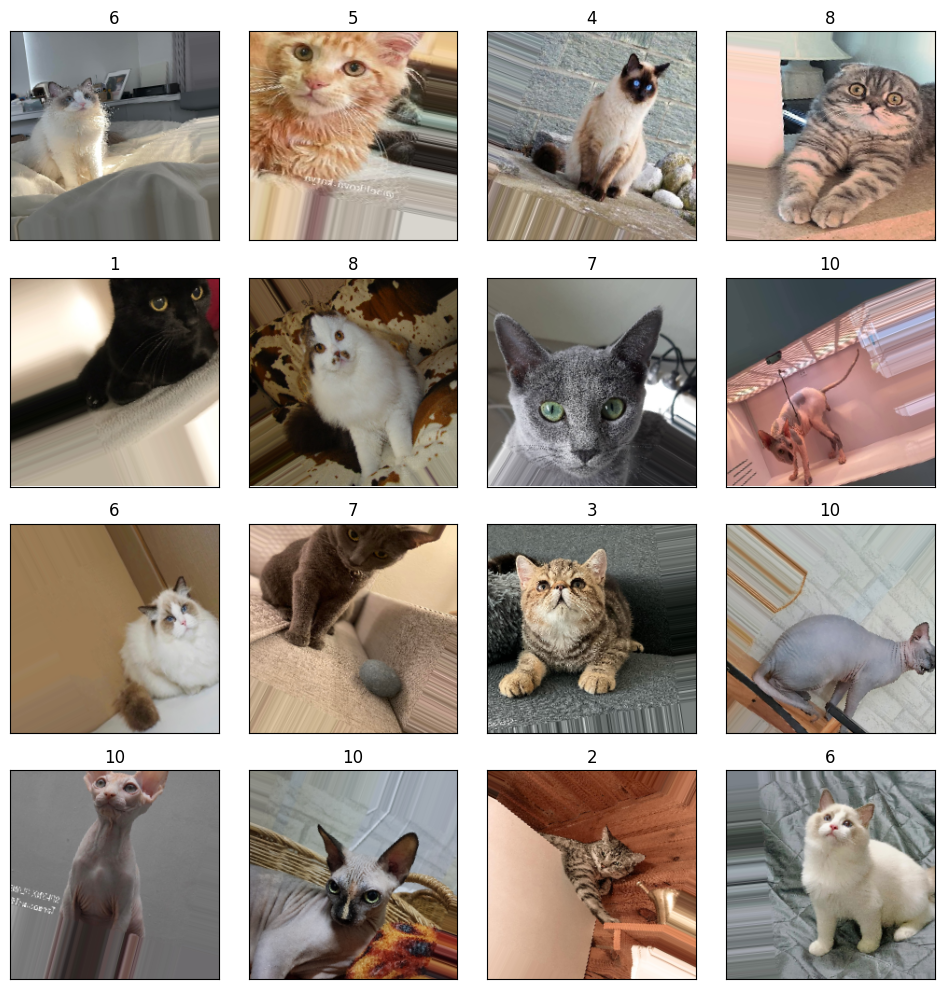

In [ ]:
features, target = next(train_datagen_aug)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title(int(target[i]))
    plt.tight_layout()

Проведем повторное обучение модели с теми же параметрами

In [ ]:
# Компилируем и обучаем модель
model_CNN.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [ ]:
hist_CNN = model_CNN.fit(train_datagen_aug,
          validation_data=val_datagen_aug, batch_size = batch_size,
          # Чтобы обучение не было слишком долгим, указываем
          # количество эпох равным 5
          epochs=5)


Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.2326 - loss: 2.3072 - val_accuracy: 0.2348 - val_loss: 2.2759
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.2722 - loss: 2.1205 - val_accuracy: 0.2193 - val_loss: 2.2123
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.2577 - loss: 2.1694 - val_accuracy: 0.2757 - val_loss: 2.0662
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.3015 - loss: 2.0224 - val_accuracy: 0.3858 - val_loss: 1.8590
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.2943 - loss: 2.0698 - val_accuracy: 0.2056 - val_loss: 2.3606


Изобразим кривые обучения

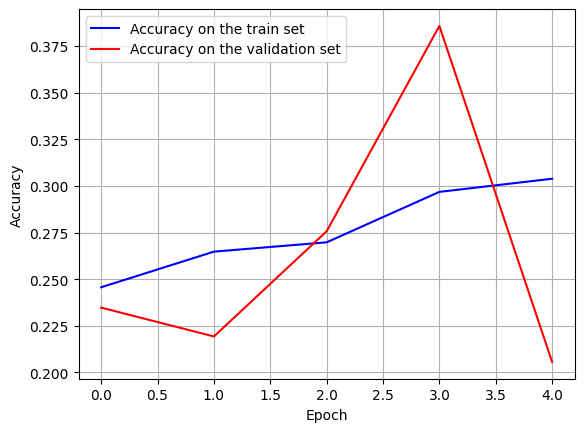

In [ ]:
plt.plot(hist_CNN.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_CNN.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

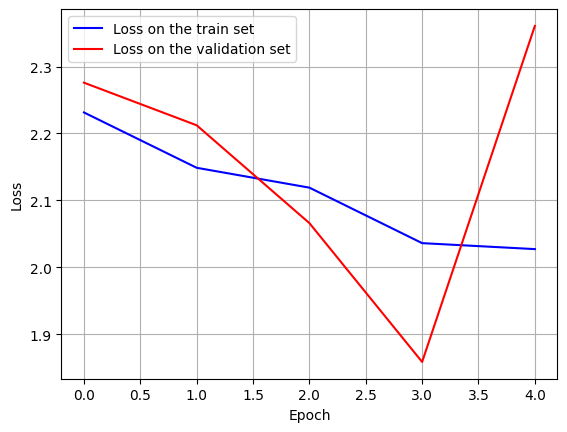

In [ ]:
plt.plot(hist_CNN.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_CNN.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Для сохранения обученной модели и ее весовых коэффициентов, найденных после обучения, необходимо создать файл json

In [ ]:
print("Сохраняем сеть")
model_json = model_CNN.to_json()
json_file = open('Cats_CNN.json', 'w')
json_file.write(model_json)
json_file.close()
model_CNN.save_weights('Cats_CNN.weights.h5')
print("Сохранение сети завершено")

Сохраняем сеть
Сохранение сети завершено


In [ ]:
# Загружаем данные об архитектуре сети из файла json
json_file = open('Cats_CNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()


In [ ]:
# Теперь можно просто загрузить обученную модель и использовать ее для других наборов данных.
#Создаем модель на основе загруженных данных
loaded_model = keras.models.model_from_json(loaded_model_json)
# Загружаем веса в модель
loaded_model.load_weights('Cats_CNN.weights.h5')

In [ ]:
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,638,083 (6.25 MB)

 Trainable params: 545,899 (2.08 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 1,091,800 (4.16 MB)

## Перенос обучения (transfer learning)

Архитектуру `ResNet50` можно импортировать из `Keras` следующим образом. Число 50 означает количество слоёв в сети.

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(input_shape=None,
                         classes=1000,
                         include_top=True,
                       weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

Аргументы:
* `input_shape` — размер входного изображения. Например: (640, 480, 3).
* `classes=1000` — количество нейронов в последнем полносвязном слое, в котором выполняется классификация.
* `weights='imagenet'` (от англ. «сеть изображений») — инициализация весов. `ImageNet` — название большого датасета, на котором сеть обучалась классифицировать изображения на 1000 классов. Если обучение сети начать на `ImageNet`, а продолжить на вашей задаче, результат будет лучше, чем если обучать с нуля. Чтобы инициализация весов была случайной, напишите `weights=None`.
* `include_top=True` (англ. «добавить верхушку») — указание на то, что в конце архитектуры `ResNet` есть два слоя: `GlobalAveragePooling2D` и `Dense`. Если задать `False`, то этих слоёв не будет.

Последние слои:
* `GlobalAveragePooling2D` (англ. «глобальный двумерный пулинг усреднением») — пулинг с окном во весь тензор. Как и `AveragePooling2D`, возвращает среднее значение из группы пикселей внутри канала. `GlobalAveragePooling2D` нужен, чтобы усреднить информацию по всему изображению, то есть получить пиксель с большим количеством каналов (например, 512 для `ResNet50`).
* `Dense` — полносвязный слой для классификации.

Чтобы адаптировать `ResNet50` к нашей задаче, нужно убрать верхушку и сконструировать её заново:

In [ ]:
backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

model = keras.Sequential([
    backbone,
    GlobalAveragePooling2D(),
    Dense(11, activation='softmax')
    ])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


где `backbone` (англ. «костяк») — то, что осталось от `ResNet50`.

Чтобы избежать переобучения этой модели на наших данных, «заморозим» часть сети: если некоторые слои оставить с весами из `ImageNet`, они не будут обучаться градиентным спуском. Обучим только 1–2 полносвязных слоя наверху сети. Так количество параметров в сети уменьшится, но архитектура сохранится.
Вот как это сделать:

In [ ]:
backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

# замораживаем ResNet50 без верхушки
backbone.trainable = False

model_ResNet50 = keras.Sequential([
    backbone,
    GlobalAveragePooling2D(),
    Dense(11, activation='softmax')
])


Чтобы сеть обучалась, добавленный сверху `backbone` полносвязный слой замораживать не стали.

Заморозка позволяет избавиться от переобучения и повысить скорость обучения сети:  градиентному спуску считать производные для замороженных слоёв не нужно.

Теперь компилируем и обучаем модель.

In [ ]:
# Компилируем и обучаем модель
model_ResNet50.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


hist_ResNet50 = model_ResNet50.fit(train_datagen_flow,
          validation_data=val_datagen_flow, batch_size = batch_size,
          # Чтобы обучение не было слишком долгим, указываем
          # количество эпох равным 10
          epochs=10)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.1000 - loss: 2.4676 - val_accuracy: 0.0965 - val_loss: 2.3669
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 73s 986ms/step - accuracy: 0.1240 - loss: 2.3657 - val_accuracy: 0.1965 - val_loss: 2.3365
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 987ms/step - accuracy: 0.1533 - loss: 2.3413 - val_accuracy: 0.1829 - val_loss: 2.3136
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1826 - loss: 2.3189 - val_accuracy: 0.1483 - val_loss: 2.3148
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 999ms/step - accuracy: 0.1720 - loss: 2.3090 - val_accuracy: 0.2138 - val_loss: 2.2756
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.2044 - loss: 2.2746 - val_accuracy: 0.1793 - val_loss: 2.2562
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 958ms/step - accuracy: 0.1910 - loss: 2.2684 - val_accuracy: 0.2220 - val_loss: 2.2321
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 968ms/step - accuracy: 0.2204 - loss: 2.2387 - val_accuracy: 0.

Кривые обучения

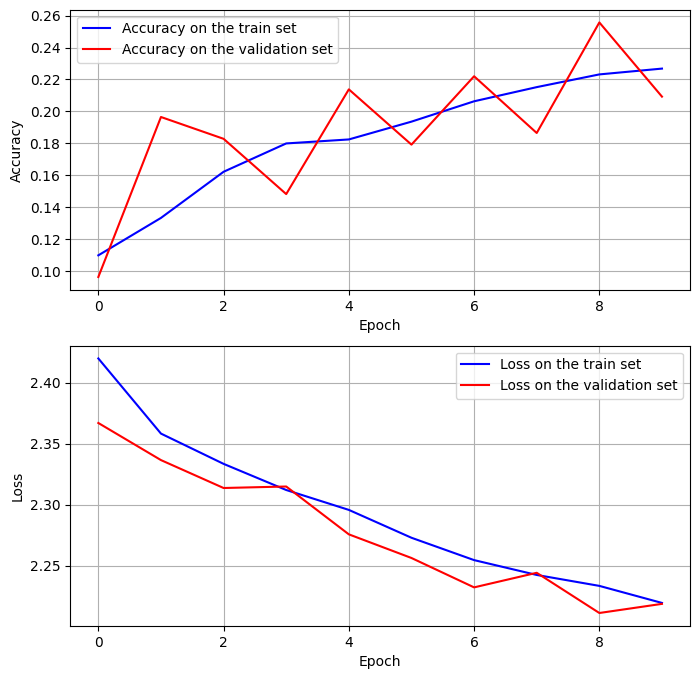

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_ResNet50.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_ResNet50.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(hist_ResNet50.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_ResNet50.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
backbone.trainable = True
trainable=False

for layers in model_ResNet50.layers:
  if layers.name=='conv5_block3':
    trainable=True
  layers.trainable=trainable

ResNet50_fine_tune = keras.Sequential([
    backbone,
    GlobalAveragePooling2D(),
    #BatchNormalization(),
    Dense(11, activation='softmax')
])

In [ ]:
ResNet50_fine_tune.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


hist_ResNet50_fine_tune = ResNet50_fine_tune.fit(train_datagen_flow,
          validation_data=val_datagen_flow, batch_size =  batch_size,
          # Чтобы обучение не было слишком долгим, указываем
          # количество эпох равным 10
          epochs=10)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.0915 - loss: 2.6161 - val_accuracy: 0.0919 - val_loss: 2.5663
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.0853 - loss: 2.5539 - val_accuracy: 0.0919 - val_loss: 2.5190
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 132s 991ms/step - accuracy: 0.0866 - loss: 2.5069 - val_accuracy: 0.0910 - val_loss: 2.4851
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 74s 994ms/step - accuracy: 0.0847 - loss: 2.4782 - val_accuracy: 0.0910 - val_loss: 2.4603
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 979ms/step - accuracy: 0.0863 - loss: 2.4519 - val_accuracy: 0.0919 - val_loss: 2.4424
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 991ms/step - accuracy: 0.0893 - loss: 2.4334 - val_accuracy: 0.0928 - val_loss: 2.4292
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.0851 - loss: 2.4242 - val_accuracy: 0.0901 - val_loss: 2.4198
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 73s 992ms/step - accuracy: 0.0922 - loss: 2.4128 - val_accuracy: 0.

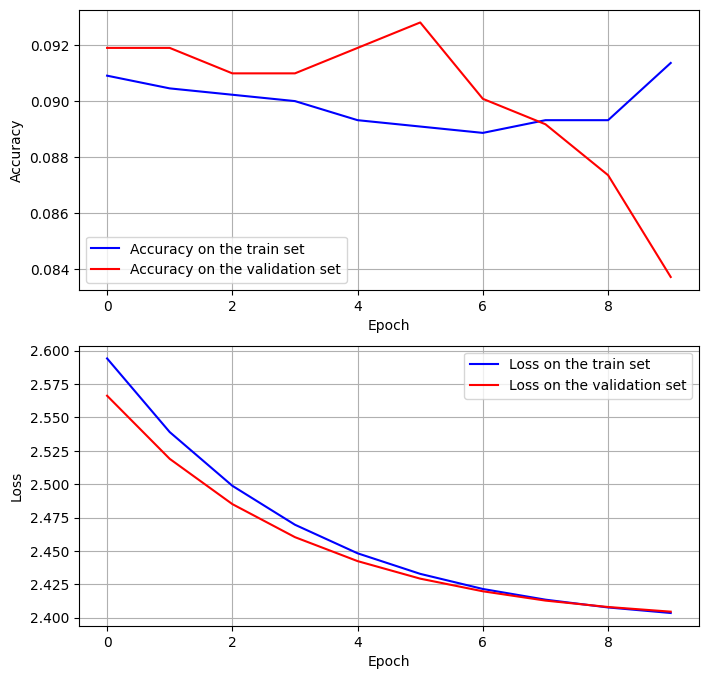

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_ResNet50_fine_tune.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_ResNet50_fine_tune.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(hist_ResNet50_fine_tune.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_ResNet50_fine_tune.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Тонкая настройка (fine tuning)

Тонкая настройка подразумевать следующий этап обучения после того, как мы обучили часть нашей новой составной сети, которая отвечает за классификацию. Мы можем дообучить и свёрточную часть сети для того, чтобы лучше распознавать характерные особенности наших объектов. Для этого нам нужно "разморозить" один или несколько свёрточных слоев.

# MobileNet

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions


In [ ]:
model1 = MobileNet(input_shape=None,
                         classes=1000,
                         include_top=True,
                       weights='imagenet')
model1.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
backbone = MobileNet(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

model_mobilenet = keras.Sequential([
    backbone,
    GlobalAveragePooling2D(),
    Dense(11, activation='softmax')
    ])

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
backbone = MobileNet(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

# замораживаем ResNet50 без верхушки
backbone.trainable = False

model_mobilenet = keras.Sequential([
    backbone,
    GlobalAveragePooling2D(),
    Dense(11, activation='softmax')
])

In [ ]:
# Компилируем и обучаем модель
model_mobilenet.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


hist_mobilenet  = model_mobilenet.fit(train_datagen_flow,
          validation_data=val_datagen_flow, batch_size = batch_size,
          # Чтобы обучение не было слишком долгим, указываем
          # количество эпох равным 10
          epochs=10)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.4290 - loss: 1.7990 - val_accuracy: 0.8590 - val_loss: 0.5259
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 123s 952ms/step - accuracy: 0.9011 - loss: 0.4138 - val_accuracy: 0.9072 - val_loss: 0.3381
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9383 - loss: 0.2595 - val_accuracy: 0.9217 - val_loss: 0.2703
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 70s 943ms/step - accuracy: 0.9567 - loss: 0.1969 - val_accuracy: 0.9299 - val_loss: 0.2349
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9679 - loss: 0.1550 - val_accuracy: 0.9308 - val_loss: 0.2225
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 73s 967ms/step - accuracy: 0.9693 - loss: 0.1398 - val_accuracy: 0.9418 - val_loss: 0.1936
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9797 - loss: 0.1103 - val_accuracy: 0.9427 - val_loss: 0.1855
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 74s 924ms/step - accuracy: 0.9829 - loss: 0.0911 - val_accuracy: 0.947

# Сравнение моделей

In [ ]:
#model_CNN.evaluate(x_test, y_test_cat)

NameError: name 'x_test' is not defined

In [ ]:
#model_ResNet50.evaluate(x_test, y_test_cat)

In [ ]:
#ResNet50_fine_tune.evaluate(x_test, y_test_cat)

In [ ]:
#model_mobilenet.evaluate(x_test, y_test_cat)

In [ ]:
from IPython.display import Image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image

In [ ]:
filename  = "/content/drive/MyDrive/машинное зрение/koshka-regdoll (1).jpg"

<PIL.Image.Image image mode=RGB size=224x224 at 0x7DA14E0F78B0>


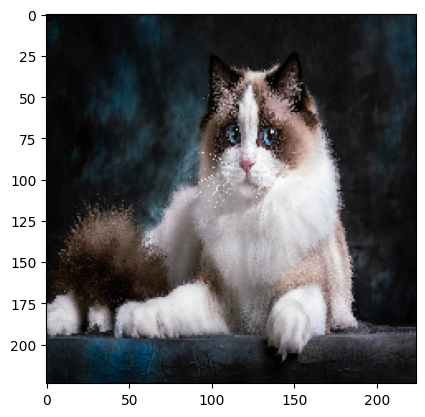

In [ ]:
Image(filename,width=224,height=224)
img = image.load_img(filename,target_size=(224,224))
print(img)
plt.imshow(img)

In [ ]:
resizedimg = image.img_to_array(img)
finalimg = np.expand_dims(resizedimg,axis=0)

In [ ]:
pred_CNN = model_CNN.predict(finalimg)
print(np.argmax(pred_CNN))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
0


In [ ]:
pred_ResNet50 = model_ResNet50.predict(finalimg)
print(np.argmax(pred_ResNet50))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1


In [ ]:
pred_ResNet50_fine_tune = ResNet50_fine_tune.predict(finalimg)
print(np.argmax(pred_ResNet50_fine_tune))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
4


In [ ]:
pred_model_mobilenet = model_mobilenet.predict(finalimg)
print(np.argmax(pred_model_mobilenet))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3


<PIL.Image.Image image mode=RGB size=224x224 at 0x7DA14E0F7370>


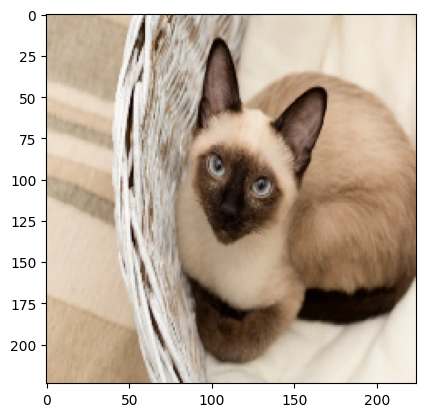

In [ ]:
siam  = "/content/drive/MyDrive/машинное зрение/Siamese 1.jpg"
Image(siam,width=224,height=224)
img = image.load_img(siam,target_size=(224,224))
print(img)
plt.imshow(img)

In [ ]:
resizedimg2 = image.img_to_array(img)
finalimg2 = np.expand_dims(resizedimg,axis=0)
finalimg = tf.keras.applications.mobilenet.preprocess_input(finalimg)
finalimg.shape
predictions = model_mobilenet.predict(finalimg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
print(np.argmax(predictions))

4


In [ ]:
pred_model_mobilenet = model_mobilenet.predict(finalimg2)
print(np.argmax(pred_model_mobilenet))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3


In [ ]:
pred_ResNet50_fine_tune = ResNet50_fine_tune.predict(finalimg2)
print(np.argmax(pred_ResNet50_fine_tune))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4
